# 5.4 단순한 계층 구현하기
- 곱셈 노드: MulLayer
- 덧셈 노드: AddLayer

곱셈 계층

In [1]:
class MulLayer:
    def __init(self):
        self.x = None
        slef.y = None

    def forward(self, x, y): # 순전파
        self.x = x
        self.y = y
        out = x*y
        return out

    def backward(self, dout): # 역전파
        dx = dout*self.y
        dy = dout*self.x
        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [3]:
# 역전파
dprice=1
dapple_price, dtax = mul_tax_layer.backward(dprice) # 입력한 순서대로 넣어야 한다.
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


덧셈 계층


In [4]:
class AddLayer:
    def __init__(self):
        pass
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [5]:
apple = 100
orange = 150
apple_num = 2
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()  # 한 층마다 하나의 MulLayer()이 아니라, 노드마다 하나씩 필요하다.
mul_orange_layer = MulLayer()
add_fruit_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
fruit_price = add_fruit_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(fruit_price, tax)

# 역전파
dprice=1
dfruit_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_fruit_layer.backward(dfruit_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(dapple, dapple_num, dorange, dorange_num, dtax)

2.2 110.00000000000001 3.3000000000000003 165.0 650


# 5.5 활성화 함수 계층 구현하기
ReLu, Sigmoid

ReLu 계층

In [6]:
class ReLu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0   # 0보다 작은 부분이 True 
        return out

    def backward(self, dout):
        dout[self.mask] = 0 # 0보다 작은 부분은 0
        dx = dout
        return dx

In [7]:
import numpy as np
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [8]:
mask = (x<=0)
print(mask)

[[False  True]
 [ True False]]


Sigmoid 계층

In [9]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out=1/(1+np.exp(-x))
        self.out=out
        return out

    def backward(self, dout):
        dx=dout*(1.0-self.out)*self.out # dout * y(1-y)

# 5.6 Affine/Softmax 계층 구현하기

어파인(affine) 계층: 입력에 가중치를 곱하고 편향을 더하는 일련의 과정을 일컫는다.<br>
만약, 입력이 행렬이라면?
- 행렬 곱(내적): 스칼라 곱처럼 다른 노드의 입력을 곱하지만, 여기서는 다른 입력의 '전치행렬'을 곱한다.
- 행렬 합: 스칼라 합처럼 기울기는 유지된다.

In [10]:
X_dot_W=np.array([[0,0,0], [10,10,10]])
B=np.array([1,2,3])
X_dot_W+B             # 차원만 같다면, NumPy의 브로드케스팅으로 인해 데이터마다 편향이 더해진다.

array([[ 1,  2,  3],
       [11, 12, 13]])

In [11]:
dY=np.array([[1,2,3], [4,5,6]])
dB=np.sum(dY, axis=0)  # 출력에는 배치 수만큼 편향이 더해지기 때문에, 편향이 출력에 미친 모든 영향을 더해야한다.
dB

array([5, 7, 9])

In [12]:
# Affine 계층 구현

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.dx = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W)+self.b
        return out

    # 실제 CNN의 이미지 인식에서는 데이터가 다차원(4차원)으로 입력되기 때문에 '텐서 대응'이 필요하다. -> layer.py 파일 참고할 것.
    # 4차원 데이터 x.shapee = (배치 크기, 채널 수, height, width), 픽셀은 height과 width으로 결정되고 채널은 한 픽셀 들어갈 수 있는 feature의 개수를 의미한다. 

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        dW = np.dot(dout, self.x.T)
        self.db = np.sum(dout, axis=0)
        return dx                      # 역전파의 목적은 다음 계층으로 기울기를 넘겨야하기 때문에 dx만 반환했다.
                                       # dW와 db는 각 계층에 저장만 해두었다가, 나중에 optimizer가 업데이트한다.

### Softmax-with-Loss 계층
역전파의 입력의 기본 형태 = 신경망의 현재 출력 - 정답 레이블<br>
기본 형태에 맞게, 분류는 '소프트맥스 함수-교차 엔트로피 오차'를 적용하고 회귀는 '항등 함수 - 오차제곱합'을 적용한다.

In [13]:
class SoftmaxLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y-self.t)/batch_size # 역전파에서는 데이터 1개당 오차를 전달하므로 배치 사이즈로 나눈다.
        return dx

# 5.7 오차역전파법 구현하기

In [14]:
from mnist import load_mnist
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()   # layers는 순서를 기억하는 딕셔리리
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastlayer = SoftmaxWithLoss() # 출력층은 softmax with loss

    # 순전파에서는 저장한 순서대로 계층을 만난다.
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax( y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy

    # 수치 해석
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    # 해석적으로 기울기 구하는 방법
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout =1
        dout = self.lastlayer.backward(dout) # 역전파의 입력은 신경망 출력 - 정답 레이블

        layers = list(self.layers.values())
        layers.reverse() # 계층의 순서를 뒤집어서 역전파의 순서로 바꾼다.
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

수치미분은 오래 걸리지만, 오차역전파 법을 검사하기 위해 필요하다.

In [15]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size = 10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후, 그 절댓값들의 평균을 낸다.
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:4.1310786141938275e-10
b1:2.5464088509986015e-09
W2:5.083615999297922e-09
b2:1.4083904897460587e-07


해석적으로 구한 기울기(오차역전파 법)과 수치해석으로 구한 기울기의 차이가 작다는 것을 알려준다.

### 오차역전파 법을 활용한 학습 구현하기

In [16]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 시각화 용 변수
num=0
num_iter=[]

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:    # 중간중간 성능 확인을 위함 -> 하지만, 과적합 방지를 위해 early stop도 필요하다.
        num+=1
        num_iter.append(num)
        
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.04275 0.0386
0.8988166666666667 0.903
0.9215833333333333 0.9248
0.93425 0.9341
0.9433333333333334 0.9397
0.94915 0.9466
0.9551 0.9516
0.9566833333333333 0.9536
0.9634 0.9579
0.9661 0.9604
0.9681 0.962
0.9703833333333334 0.9635
0.9717833333333333 0.9662
0.9739833333333333 0.9677
0.9745666666666667 0.9675
0.9766333333333334 0.9683
0.97755 0.969


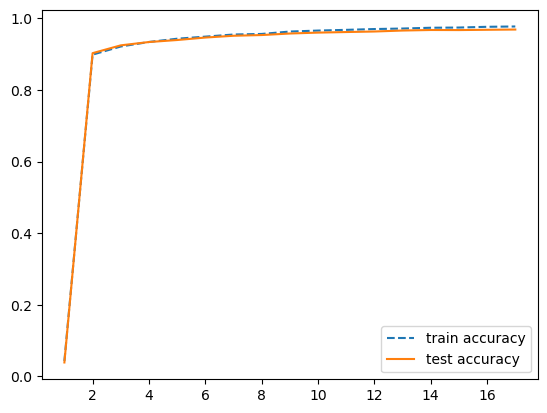

In [17]:
import matplotlib.pyplot as plt
plt.plot(num_iter, train_acc_list, linestyle='--', label='train accuracy')
plt.plot(num_iter, test_acc_list, label='test accuracy')
plt.legend()
plt.show()

오차역전파법에서 iter_num 만큼 반복 학습한다.<br>
각 계층의 가중치와 편향이 오차에 얼마나 기여하는지(기울기)를 구하고 학습률을 곱해서 빼준다.<br>
그러므로 **자연스럽게 기울기가 큰 파라미터는 크게, 작은 파라미터는 조금만 수정**하게 되는 것이다.<br>
이런 원리 덕분에, 몇번의 반복만으로 정확도가 크게 증가한다.